In [1]:
import sys
import jax.numpy as jnp
import numpy as np
from trax import layers as tl
from trax.shapes import signature
from trax.layers import combinators as cb
from trax.layers.assert_shape import assert_shape

sys.path.insert(0, "../..")
from src.models.build import summary
from pathlib import Path
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
%matplotlib inline

/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation: int = Image.BICUBIC,


In [2]:
data_dir = Path("../../data/raw/")

In [3]:
from torchvision import datasets
training_data = datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
from src.data.data_tools import BaseDatastreamer
from typing import Iterator

class VAEstreamer(BaseDatastreamer):
    def stream(self) -> Iterator:
        while True:
            if self.index > (self.size - self.batchsize):
                self.reset_index()
            batch = self.batchloop()
            X_, _ = zip(*batch)
            X = np.stack(X_)
            X = X.transpose(0, 2, 3, 1)
            yield X, X

In [5]:
trainstream = VAEstreamer(dataset=training_data, batchsize=32).stream()
teststream = VAEstreamer(dataset=test_data, batchsize=32).stream()

In [6]:
X, Y = next(trainstream)
X.shape, Y.shape

((32, 28, 28, 1), (32, 28, 28, 1))

In [7]:
hidden = 32
latent = 2

In [8]:
def Encoder(hidden: int, latent: int):
    encoder = cb.Serial(
        tl.Flatten(),
        tl.Dense(250),
        tl.Relu(),
        tl.Dense(100),
        tl.Relu(),
        tl.Dense(latent)
    ) 
    return encoder
encoder = Encoder(hidden, latent)
encoder.init_weights_and_state(signature(X))
summary(encoder, X)

layer                   input                dtype     output               dtype 
(0) Flatten_keep1       (32, 28, 28, 1)    (float32) | (32, 784)          (float32)
(1) Dense_250           (32, 784)          (float32) | (32, 250)          (float32)
(2) Relu                (32, 250)          (float32) | (32, 250)          (float32)
(3) Dense_100           (32, 250)          (float32) | (32, 100)          (float32)
(4) Relu                (32, 100)          (float32) | (32, 100)          (float32)
(5) Dense_2             (32, 100)          (float32) | (32, 2)            (float32)


ShapeDtype{shape:(32, 2), dtype:float32}

In [9]:
def Expand(shape):
    def f(x):
        return x.reshape(shape)
    return tl.Fn("Expand", f)

In [10]:
z = encoder(X)
z.shape

(32, 2)

In [11]:
def Decoder(hidden: int):
    decoder = cb.Serial(
        tl.Dense(100),
        tl.Relu(),
        tl.Dense(250),
        tl.Relu(),
        tl.Dense(28*28),
        Expand((-1, 28, 28, 1))
    ) 
    return decoder

decoder = Decoder(hidden)
decoder.init_weights_and_state(signature(z))
summary(decoder, z)

layer                   input                dtype     output               dtype 
(0) Dense_100           (32, 2)            (float32) | (32, 100)          (float32)
(1) Relu                (32, 100)          (float32) | (32, 100)          (float32)
(2) Dense_250           (32, 100)          (float32) | (32, 250)          (float32)
(3) Relu                (32, 250)          (float32) | (32, 250)          (float32)
(4) Dense_784           (32, 250)          (float32) | (32, 784)          (float32)
(5) Expand              (32, 784)          (float32) | (32, 28, 28, 1)    (float32)


ShapeDtype{shape:(32, 28, 28, 1), dtype:float32}

In [12]:
def ReconstructionLoss():
    def f(y, yhat):
        squared_error = (y-yhat)**2
        summed = jnp.sum(squared_error, axis=[1,2,3])
        return summed.mean()
    return tl.Fn("recostructionLoss", f)
    

In [13]:
@assert_shape('bwhc->bwhc')
def AutoEncoder(hidden: int, latent: int):
    encoder = Encoder(hidden, latent)
    decoder = Decoder(hidden)
    model = cb.Serial(
        encoder,
        decoder
    )
    return model


In [14]:
model = AutoEncoder(hidden=32, latent=2)
model.init_weights_and_state(signature(X))
summary(model, X)

layer                   input                dtype     output               dtype 
(0) Flatten_keep1       (32, 28, 28, 1)    (float32) | (32, 784)          (float32)
(1) Dense_250           (32, 784)          (float32) | (32, 250)          (float32)
(2) Relu                (32, 250)          (float32) | (32, 250)          (float32)
(3) Dense_100           (32, 250)          (float32) | (32, 100)          (float32)
(4) Relu                (32, 100)          (float32) | (32, 100)          (float32)
(5) Dense_2             (32, 100)          (float32) | (32, 2)            (float32)
(1) Dense_100           (32, 2)            (float32) | (32, 100)          (float32)
(2) Relu                (32, 100)          (float32) | (32, 100)          (float32)
(3) Dense_250           (32, 100)          (float32) | (32, 250)          (float32)
(4) Relu                (32, 250)          (float32) | (32, 250)          (float32)
(5) Dense_784           (32, 250)          (float32) | (32, 784)          (fl

ShapeDtype{shape:(32, 28, 28, 1), dtype:float32}

In [15]:
model.n_in, model.n_out

(1, 1)

In [16]:
from trax.supervised import training
from src.data import data_tools
import trax

model = AutoEncoder(hidden=32, latent=2)
log_dir = "../../models/trax"
log_dir = data_tools.dir_add_timestamp(log_dir)

train_task = training.TrainTask(
    labeled_data=trainstream,
    loss_layer=ReconstructionLoss(),
    optimizer=trax.optimizers.Adam(),
)

eval_task = training.EvalTask(
    labeled_data=teststream, metrics=[ReconstructionLoss()], n_eval_batches=25
)

loop = training.Loop(
    model,
    train_task,
    eval_tasks=[eval_task],
    output_dir=log_dir,
)

2022-06-10 22:14:00.815 | INFO     | src.data.data_tools:dir_add_timestamp:228 - Logging to ../../models/trax/20220610-2214
/Users/rgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-xB8KIJr7-py3.9/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:429: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


In [17]:
loop.run(4000)


Step      1: Total number of trainable weights: 443886
Step      1: Ran 1 train steps in 3.16 secs
Step      1: train recostructionLoss |  86.62885284
Step      1: eval  recostructionLoss |  89.49312592

Step    100: Ran 99 train steps in 1.18 secs
Step    100: train recostructionLoss |  65.92717743
Step    100: eval  recostructionLoss |  50.39769363

Step    200: Ran 100 train steps in 1.25 secs
Step    200: train recostructionLoss |  49.13953781
Step    200: eval  recostructionLoss |  48.71403503

Step    300: Ran 100 train steps in 1.06 secs
Step    300: train recostructionLoss |  46.81346512
Step    300: eval  recostructionLoss |  46.06724167

Step    400: Ran 100 train steps in 0.93 secs
Step    400: train recostructionLoss |  44.96322632
Step    400: eval  recostructionLoss |  43.38221359

Step    500: Ran 100 train steps in 0.87 secs
Step    500: train recostructionLoss |  44.35173416
Step    500: eval  recostructionLoss |  43.58840942

Step    600: Ran 100 train steps in 0.93 

In [18]:
from tqdm import tqdm
def plot_grid(img, k=3):
    fig, axs = plt.subplots(k, k, figsize=(10,10))
    axs = axs.ravel()
    for i in tqdm(range(k*k)):
        axs[i].imshow(img[i], cmap='gray')
        axs[i].axis("off")

100%|██████████| 9/9 [00:00<00:00, 96.53it/s]


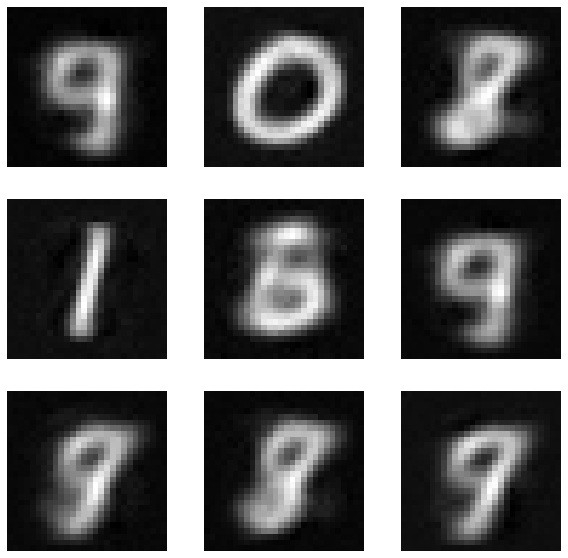

In [19]:
X, Y = next(teststream)
img = model(X)
plot_grid(img)

In [20]:
encoder = model.sublayers[1].sublayers[0]
y = encoder(X)
summary(encoder, X)

layer                   input                dtype     output               dtype 
(0) Flatten_keep1       (32, 28, 28, 1)    (float32) | (32, 784)          (float32)
(1) Dense_250           (32, 784)          (float32) | (32, 250)          (float32)
(2) Relu                (32, 250)          (float32) | (32, 250)          (float32)
(3) Dense_100           (32, 250)          (float32) | (32, 100)          (float32)
(4) Relu                (32, 100)          (float32) | (32, 100)          (float32)
(5) Dense_2             (32, 100)          (float32) | (32, 2)            (float32)


ShapeDtype{shape:(32, 2), dtype:float32}

In [26]:
from torch.utils.tensorboard import SummaryWriter
import tensorboard as tb
import tensorflow as tf
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
import torch

writer = SummaryWriter(log_dir="../../models/embeddings/")
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(test_data.data, test_data.targets)


img = images.numpy()[..., None]
emb = encoder(img)

# features = images.view(-1, 28 * 28)
writer.add_embedding(emb.to_py(),
                    metadata=labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [22]:
minmax = []
for _ in range(10):
    X, _ = next(teststream)
    y = encoder(X)
    minmax.append(y.min())
    minmax.append(y.max())
minmax = np.array(minmax)
minmax.min(), minmax.max()

(-9.954943, 12.042995)

In [23]:
decoder = model.sublayers[1].sublayers[1]
k = 20
x = np.linspace(minmax.min(), minmax.max(), k)
y = np.linspace(minmax.min(), minmax.max(), k)
xx, yy = np.meshgrid(x, y)
grid = np.c_[xx.ravel(), yy.ravel()]
grid.shape

(400, 2)

100%|██████████| 400/400 [00:00<00:00, 508.52it/s]


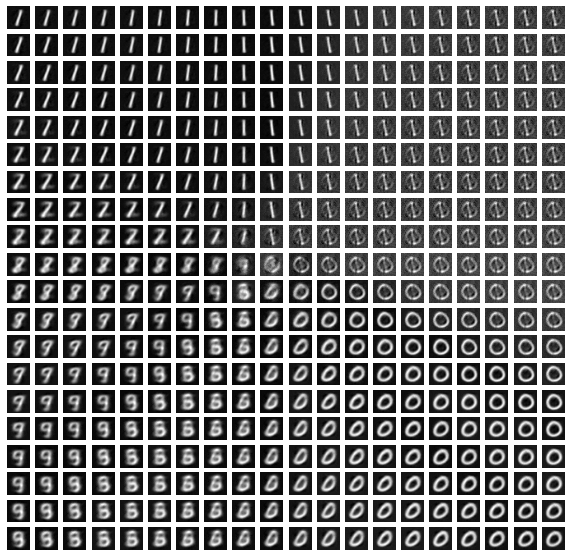

In [25]:
img = decoder(grid)
plot_grid(img, k=k)